In [12]:
import pandas as pd 
import numpy as np
import chess
import torch

chess_path = './data/chessData.csv'

df = pd.read_csv(chess_path)

piece_list = ['pawn','knight','bishop','rook','queen','king']
piece_key = range(1,7)

piece_dict = dict(zip(piece_list, piece_key))

colour_dict = {'black':0, 'white':1}


def fen_translator(fen_string: str):
    
    board = chess.Board(fen_string)
    
    tensor = board_to_tensor(board = board)
    
    return tensor


def board_to_tensor(board: chess.Board) -> torch.Tensor:
    
    array_list = []
    
    for colour in colour_dict.values():
        for piece in piece_dict.values():
            piece_array = np.reshape(np.array(str(board.pieces(piece, colour)).replace(' ', ',').replace('.','0').replace('\n', ',').split(',')), (8,8)).astype(int)
            array_list.append(piece_array)
    
    
    array_list.append(create_ep_tensor(board))
    array_list.append(create_castle_tensor(board))
    array_list.append(create_half_move_clock_draw_tensor(board))
    array_list.append(create_to_move_tensor(board))
    
    tensor = torch.tensor(np.array(array_list))
    
    return tensor


def create_ep_tensor(board: chess.Board) -> np.ndarray:
    """
    Expects a board object and returns an 8x8 array with 1 on any ep position. 
    """
    
    
    ep_tensor = np.zeros(64)
    
    if board.ep_square:
        ep = board.ep_square
        ep_tensor[ep] = 1
        
    ep_tensor = ep_tensor.reshape(8,8)[-1::-1]
    
    return ep_tensor


def create_castle_tensor(board: chess.Board) -> np.ndarray:
    """
    Expects a board object and returns a 8x8 array with 1s in the corners where the kings may castle
    
    """
    
    castle_tensor = np.zeros(64).reshape((8,8))
    
    castling_rights = board.castling_rights
    
    pos_dict = {63: (0,7),
                56: (0,0),
                7: (7,7),
                0: (7,0)}
    
    for pos_number, pos_coordinates in pos_dict.items():
        
        if castling_rights >= 2**pos_number:
            castling_rights -= 2**pos_number
            castle_tensor[pos_coordinates] = 1
        
    return castle_tensor


def create_half_move_clock_draw_tensor(board: chess.Board) -> np.ndarray:
    
    if board.halfmove_clock>=100:
        
        return np.ones(64).reshape((8,8))
    
    else:
        
        return np.zeros(64).reshape((8,8))
    
    
def create_to_move_tensor(board: chess.Board) -> np.ndarray:
    
    if board.turn:
        return np.hstack((np.zeros(32), np.ones(32))).reshape(8,8)
    
    else:
        return np.hstack((np.ones(32), np.zeros(32))).reshape(8,8)
    
    
def evaluation_mate_handler(df: pd.DataFrame) -> pd.DataFrame:
    
    df = (df
          .dropna()
          .assign(Evaluation = lambda df: (df['Evaluation']
                                            .mask(df['Evaluation'].str.contains('#-'), '-1000000')))
          .assign(Evaluation = lambda df: (df['Evaluation']
                                            .mask(df['Evaluation'].str.contains('#+'), '1000000')))
          .assign(Evaluation = lambda df: df['Evaluation'].str.replace('\ufeff', '').str.replace(r'\s', '').str.replace('+', '').astype(int)))
    
    return df



In [13]:
df = df.pipe(evaluation_mate_handler)

/tmp/ipykernel_3233/3563937204.py:116: FutureWarning: The default value of regex will change from True to False in a future version.
  .assign(Evaluation = lambda df: df['Evaluation'].str.replace('\ufeff', '').str.replace(r'\s', '').str.replace('+', '').astype(int)))
/tmp/ipykernel_3233/3563937204.py:116: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .assign(Evaluation = lambda df: df['Evaluation'].str.replace('\ufeff', '').str.replace(r'\s', '').str.replace('+', '').astype(int)))


In [14]:
df

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26
...,...,...
12958030,r1bqkb1r/pp3ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1P...,6
12958031,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1...,84
12958032,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1BN2N2/PP2Q...,0
12958033,r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q...,115


<AxesSubplot:>

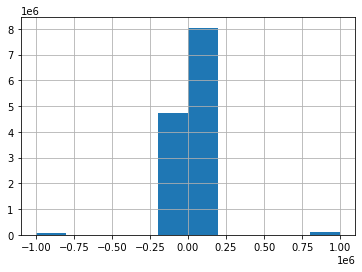

In [15]:
df['Evaluation'].hist()